## Regression Model

*We will focus on predicting a number of available bikes at a station based on the characteristics of nearby Points of Interest (POIs).*

*First, we should consider which dataset would be a better candidate for our model: museums or restobars.*

*I believe restobars data would be a better choice for the following reasons:*
<br>
<br>*- restobars typically have more varied operating hours, which could better explain bike usage patterns*
<br>*- people are likely to visit restaurants and bars more frequently, which potentially leads to more bike trips*
<br>*- restaurants and bars have more diverse characteristics (price range, popularity, ratings), this can influence bike usage* 


In [24]:
# importing neccessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

We would use the idea of **predicting the number of available bikes at a station based on POI characteristics** as our main regression model. 
<br>
<br> Still, after examining available data, I decided to include the average price of nearby restaurants as one of the predictors - we can further examine the **correlation between bike usage and choice of cheaper restaurants** as part of our EDA.

#### Preparing the data

In [7]:
# connecting to the SQLite database
conn = sqlite3.connect('oslo_data.db')

# query to join bike stations with nearby restaurants and calculate average price
query = """
SELECT 
    bs.name AS bike_station_name,
    bs.bikes_available,
    bs.slots,
    AVG(fr.Price) AS avg_restaurant_price,
    AVG(fr.Rating) AS avg_restaurant_rating,
    COUNT(fr."Foursquare Name") AS nearby_restaurant_count
FROM 
    bike_stations bs
LEFT JOIN 
    fsq_restobars fr ON (bs.latitude BETWEEN fr.Latitude - 0.001 AND fr.Latitude + 0.001)
                    AND (bs.longitude BETWEEN fr.Longitude - 0.001 AND fr.Longitude + 0.001)
GROUP BY 
    bs.name, bs.bikes_available, bs.slots
"""

df = pd.read_sql_query(query, conn)
conn.close()

# calculating occupancy rate
df['occupancy_rate'] = df['bikes_available'] / df['slots']

# displaying the first few rows and data info
print(df.head())
print(df.info())


                  bike_station_name  bikes_available  slots  \
0                   7. juni-plassen                4     21   
1                               AHO               16     20   
2                         Adamstuen                4      8   
3  Aker Brygge 1 mot Nasjonalmuseet               13     33   
4   Aker Brygge 2 mot Rådhusplassen               20     24   

   avg_restaurant_price  avg_restaurant_rating  nearby_restaurant_count  \
0                   0.0                    0.0                        1   
1                   0.0                    0.0                        1   
2                   0.0                    0.0                        1   
3                   0.0                    0.0                        3   
4                   0.0                    0.0                        3   

   occupancy_rate  
0        0.190476  
1        0.800000  
2        0.500000  
3        0.393939  
4        0.833333  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

#### Exploring correlations

Our restaurant data (`fsq_restobars` table) and other columns contain multiple values in a single cell, so if we try to calculate average prices and rating, it would give us NaN. Just to check the assumption:

In [9]:
# selecting only numerical columns for correlation
numeric_columns = ['bikes_available', 'slots', 'avg_restaurant_price', 'avg_restaurant_rating', 'nearby_restaurant_count', 'occupancy_rate']
numeric_df = df[numeric_columns]

# calculating correlation matrix
corr_matrix = numeric_df.corr()

> **STATS BREAK!**
<br> In the Oslo region, the largest percentage of international tourists come from Sweden and Denmark (14% combined), followed by Germany (11%), the USA (10%), France (6%) and the Netherlands (5%).

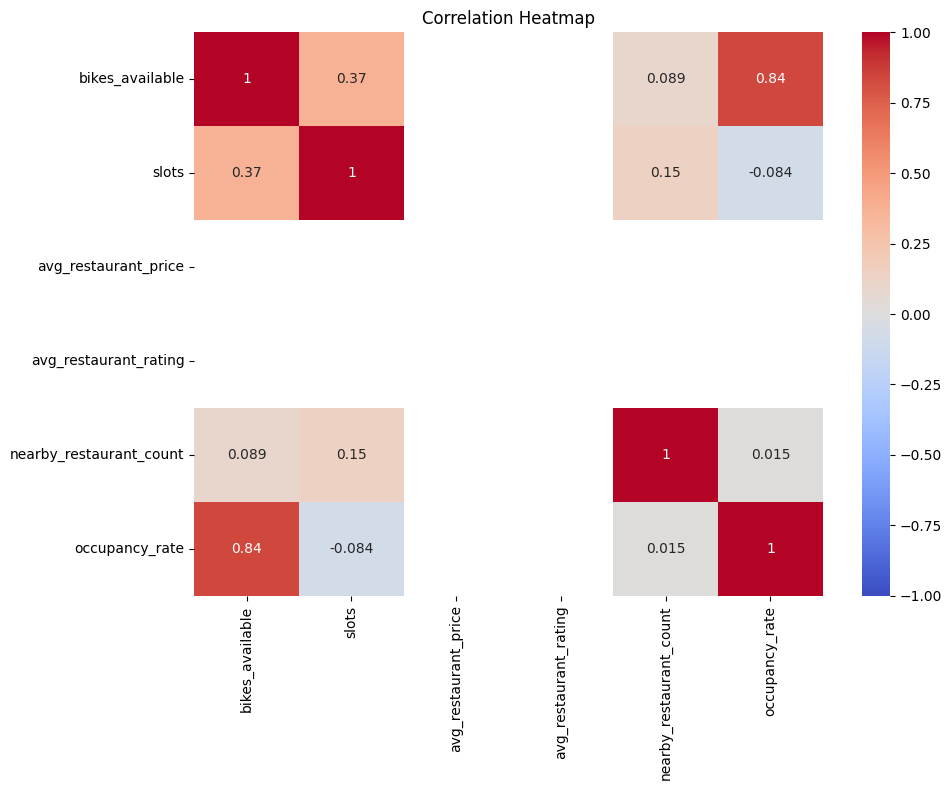

In [10]:
# heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

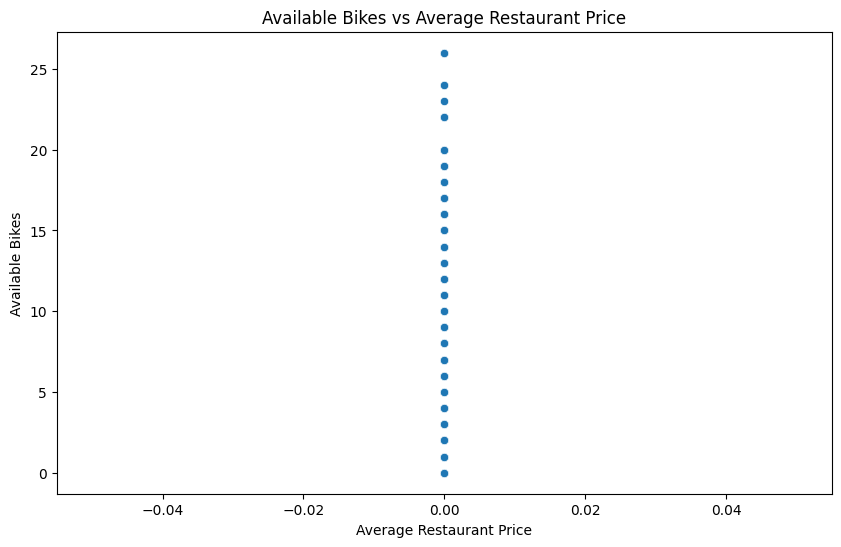

In [11]:
# scatter plot of bikes_available vs avg_restaurant_price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='avg_restaurant_price', y='bikes_available')
plt.title('Available Bikes vs Average Restaurant Price')
plt.xlabel('Average Restaurant Price')
plt.ylabel('Available Bikes')
plt.show()

In [12]:
# print correlation coefficient
print(f"Correlation between available bikes and average restaurant price: {df['bikes_available'].corr(df['avg_restaurant_price']):.2f}")

Correlation between available bikes and average restaurant price: nan


As expected, the unstructured table gave us a wrong average restaurant prices and ratings, which affected our analysis. We admit (with regret) that this correlation requires a rigorous data restructuring, which can be done later on and will not be performed as part of this project due to time constraints.
<br>
<br> Let's carry on and build a model now.

#### Building a regression model

In [29]:
# connecting to the SQLite database
conn = sqlite3.connect('oslo_data.db')

# query to join bike stations with nearby restaurants and calculate averages
query = """
SELECT 
    bs.name AS bike_station_name,
    bs.bikes_available,
    bs.slots,
    AVG(fr.Price) AS avg_restaurant_price,
    AVG(fr.Rating) AS avg_restaurant_rating,
    COUNT(fr."Foursquare Name") AS nearby_restaurant_count
FROM 
    bike_stations bs
LEFT JOIN 
    fsq_restobars fr ON (bs.latitude BETWEEN fr.Latitude - 0.001 AND fr.Latitude + 0.001)
                    AND (bs.longitude BETWEEN fr.Longitude - 0.001 AND fr.Longitude + 0.001)
GROUP BY 
    bs.name, bs.bikes_available, bs.slots
"""

# loading the data from the database
df = pd.read_sql_query(query, conn)

conn.close()

# removing rows with NaN or infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# preparing the data for regression
X = df[['avg_restaurant_price', 'avg_restaurant_rating', 'nearby_restaurant_count']]
y = df['bikes_available']

# adding constant term to the features
X = sm.add_constant(X)

# fitting the model
model = sm.OLS(y, X).fit()

# printing the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        bikes_available   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.907
Date:                Sat, 19 Oct 2024   Prob (F-statistic):              0.169
Time:                        14:48:50   Log-Likelihood:                -854.75
No. Observations:                 261   AIC:                             1714.
Df Residuals:                     259   BIC:                             1721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\AM\anaconda3\envs\new_env\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


#### Interpretation
<br> **Model Fit:** 
<br>Our R-squared value is 0.007, which is extremely low. This means that only 0.7% of the variance in bike availability is explained by our model. Our chosen predictors are not good.
<br>
<br> **Statistical Significance:**
<br> p-values indicate that the whole model is not statistically significant, considering common *alpha* of 0.05
<br> 
<br> **Coefficients:**
<br> Both `avg_restaurant_price` and `avg_restaurant_rating` are both 0, which is unusual, but considering our previous problem with a database, we know that further cleaning is required for this to work. 
<br> Coefficient for `nearby_restaurant_count` is 0.9334, suggesting that for each additional nearby restaurant, we expect an increse of about 0.93 available bikes, but there is no statistical significance here.
<br>
<br> **Overall, current model is not effective at predicting bike availability based on the given restaurant characteristics.**

Provide model output and an interpretation of the results. 

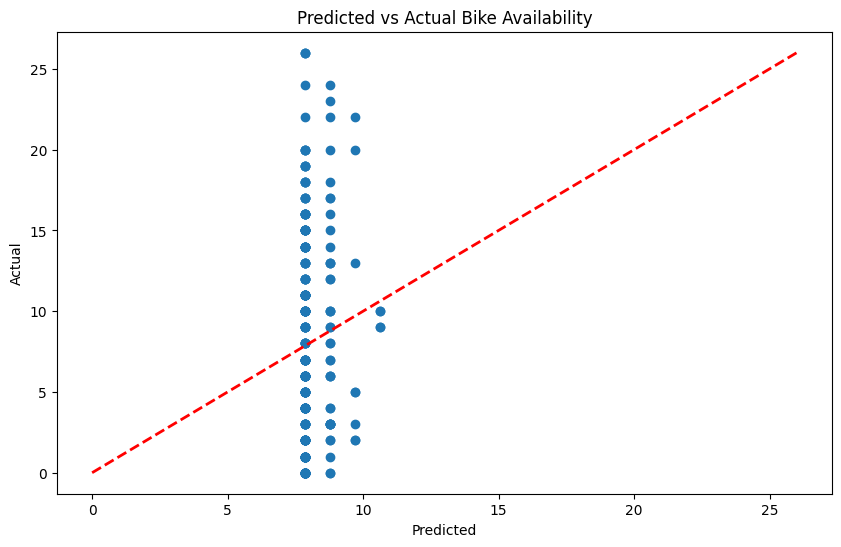

In [30]:
# visualizing the relationship between predicted and actual values
plt.figure(figsize=(10, 6))
plt.scatter(model.predict(X), y)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual Bike Availability')
plt.show()

In [31]:
# printing coefficients
print("\nCoefficients:")
for name, coef in zip(X.columns, model.params):
    print(f"{name}: {coef}")


Coefficients:
const: 6.907740621286713
avg_restaurant_price: 0.0
avg_restaurant_rating: 0.0
nearby_restaurant_count: 0.9333729417755896


In [32]:
# calculating and print R-squared
print(f"\nR-squared: {model.rsquared}")


R-squared: 0.0073083621040873625


In [33]:
# feature importance
importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(model.params)})
importance = importance.sort_values('importance', ascending=False)

<Figure size 1000x600 with 0 Axes>

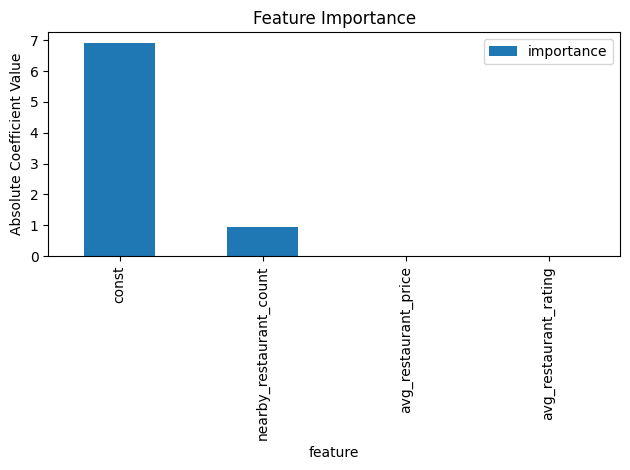

In [34]:
plt.figure(figsize=(10, 6))
importance.plot(x='feature', y='importance', kind='bar')
plt.title("Feature Importance")
plt.ylabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

Given these results, it's clear that we need to **revisit our data preparation and check for data quality issues**. We can also **consider other potential predictors** that might be more relevant to bike availability.

> **FUN FACT!**
<br>Oslo is known as Tigerstaden, or the [Tiger City](https://www.lifeinnorway.net/oslo-facts/).
<br>The most agreed-upon reason is that the Norwegian poet Bjørnstjerne Bjørnson described a fight between a horse and a tiger in his 1870 poem ‘Sidste Sang’.
<br>The tiger represented the dangerous city and the horse the safe countryside. City bosses now say Oslo is not dangerous like a tiger, but ‘happening and exciting’.

# Stretch

How can you turn the regression model into a classification model?

*We would have to reframe the problem of predicting number of available bikes to classification task.*
<br>*First, we can create categories, such as: `low` (0-5 bikes), `medium` (6-15 bikes), and `high` (16+) availability.*
<br>*Then, we create a target variable, by adding a new column `availability_category`.*
<br>*Instead of linear regression, we would use logistic regression.*
<br>*For model evaluation, instead of R-squared, we would use metrics such as: confusion metrics, accuracy, or precision.*
